# **Loading the Dataset & Exploring the Dataset:**

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("/kaggle/input/product-advertising-data/Advertising_Data.csv")
df.head()


,TV,Billboards,Google_Ads,Social_Media,Influencer_Marketing,Affiliate_Marketing,Product_Sold
0,281.42,538.80,123.94,349.30,242.77,910.10,7164.0
1,702.97,296.53,558.13,180.55,781.06,132.43,5055.0
2,313.14,295.94,642.96,505.71,438.91,464.23,6154.0
3,898.52,61.27,548.73,240.93,278.96,432.27,5480.0
4,766.52,550.72,651.91,666.33,396.33,841.93,9669.0


# Model Development:# 
I've developed a neural network model using TensorFlow/Keras, which involves defining the model architecture, preprocessing the data, training the model, and evaluating its performance.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


# Separate features (X) and target variable (y)
X = df.drop('Product_Sold', axis=1)
y = df['Product_Sold']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the Keras model
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))
optimizer = Adam(lr=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
#For educational purposes, we have chosen to set the number of epochs to 200 for faster execution, although optimal results are typically achieved with 1200 epochs.
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# Evaluate the model on the test set
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f'Mean Absolute Error on Test Set: {mae}')

# Make predictions
predictions = model.predict(X_test_scaled)


2/2 [==============================] - 0s 7ms/step - loss: 433585.5312 - mae: 532.6469
Mean Absolute Error on Test Set: 532.6469116210938
2/2 [==============================] - 0s 3ms/step


# Scenario Analysis:# 
After training the model, I've created different scenarios by generating combinations of advertising budgets for each media channel.

These scenarios aim to find the best combination of budget allocations across different advertising channels to maximize sales.

I've used the trained neural network model to predict the sales for each scenario.

In [3]:
import pandas as pd
from itertools import product

# Define channel values
channel_values = {
    'TV': range(0, 1001, 250),
    'Billboards': range(0, 1001, 250),
    'Google_Ads': range(0, 1001, 250),
    'Social_Media': range(0, 1001, 250),
    'Influencer_Marketing': range(0, 1001, 250),
    'Affiliate_Marketing': range(0, 1001, 250),
}

# Generate all combinations
combinations = list(product(*channel_values.values()))

# Create a DataFrame
df_opti = pd.DataFrame(combinations, columns=channel_values.keys())

# Assuming X contains the features for your model
# Make sure X has the same columns as your training data
X_opti = df_opti.copy()  # Make a copy of the DataFrame
X_opti_scaled = scaler.transform(X_opti)  # Scale the features using the same scaler used in training

# Predict the cost using your trained model
df_opti['pred_cost'] = model.predict(X_opti_scaled)

# Display the DataFrame
print(df_opti)


489/489 [==============================] - 1s 1ms/step
         TV  Billboards  Google_Ads  Social_Media  Influencer_Marketing  \
0         0           0           0             0                     0   
1         0           0           0             0                     0   
2         0           0           0             0                     0   
3         0           0           0             0                     0   
4         0           0           0             0                     0   
...     ...         ...         ...           ...                   ...   
15620  1000        1000        1000          1000                  1000   
15621  1000        1000        1000          1000                  1000   
15622  1000        1000        1000          1000                  1000   
15623  1000        1000        1000          1000                  1000   
15624  1000        1000        1000          1000                  1000   

       Affiliate_Marketing     pred_cost  
0

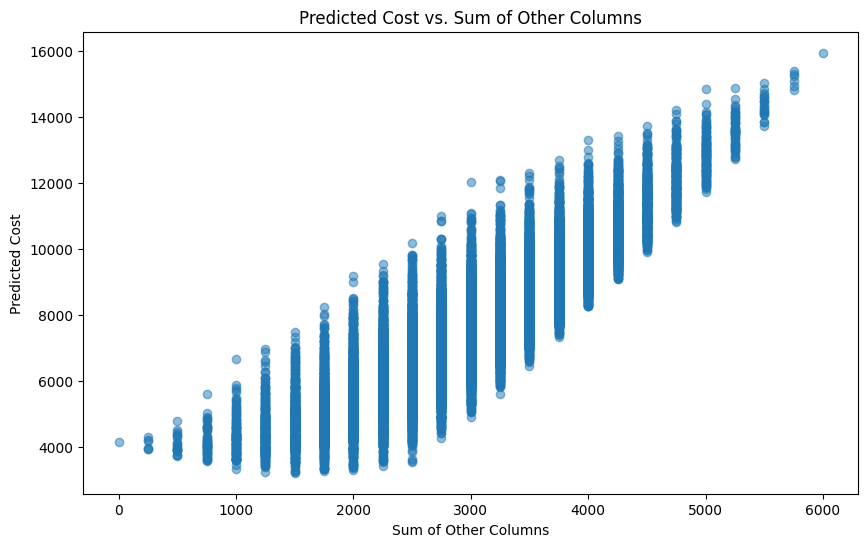

In [4]:
import matplotlib.pyplot as plt

# Calculate the sum of other columns for each row
df_opti['sum_of_other_columns'] = df_opti.drop('pred_cost', axis=1).sum(axis=1)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_opti['sum_of_other_columns'], df_opti['pred_cost'], alpha=0.5)
plt.title('Predicted Cost vs. Sum of Other Columns')
plt.xlabel('Sum of Other Columns')
plt.ylabel('Predicted Cost')
plt.show()


# Model Recommendations:
The final step involves using the model's predictions to recommend users a certain budget allocation for each advertising channel that is expected to lead to the best sales.

In [5]:
from itertools import product

def find_combinations(total_expenditure, channel_values):
    channels = list(channel_values.keys())
    combinations = []
    find_combinations_recursive(total_expenditure, channels, channel_values, 0, [], combinations)
    return combinations

def find_combinations_recursive(remaining_expenditure, channels, channel_values, index, current_combination, combinations):
    if index == len(channels):
        if remaining_expenditure == 0:
            combinations.append(current_combination.copy())
        return
    
    current_channel = channels[index]
    max_channel_value = min(remaining_expenditure, max(channel_values[current_channel]))
    
    for value in range(0, max_channel_value + 1, 100):
        current_combination.append((current_channel, value))
        find_combinations_recursive(remaining_expenditure - value, channels, channel_values, index + 1, current_combination, combinations)
        current_combination.pop()
        

# Function to calculate model output for a given combination
def calculate_model_output(combination, model, scaler):
    # Extract values from tuples
    values = [val for _, val in combination]
    df_combination = pd.DataFrame([values], columns=[channel for channel, _ in combination])
    X_combination_scaled = scaler.transform(df_combination)
    pred_cost = model.predict(X_combination_scaled)[0]
    return pred_cost

# Example usage
total_expenditure = 500  # Set your desired total expenditure here you can also change the steps in pervious clock of codes
combinations = find_combinations(total_expenditure, channel_values)


# Calculate model output for each combination
df_opti_combinations = pd.DataFrame(combinations, columns=channel_values.keys())
df_opti_combinations['pred_cost'] = df_opti_combinations.apply(calculate_model_output, axis=1, model=model, scaler=scaler)

# Sort and print the top 10 combinations by pred_cost
top_10_combinations = df_opti_combinations.sort_values(by='pred_cost', ascending=False).head(10)

print("Top 10 Combinations with Highest Predicted Cost:")
print(top_10_combinations)




1/1 [==============================] - 0s 22ms/step
Top 10 Combinations with Highest Predicted Cost:
            TV         Billboards         Google_Ads         Social_Media  \
0      (TV, 0)    (Billboards, 0)    (Google_Ads, 0)    (Social_Media, 0)   
56     (TV, 0)  (Billboards, 100)    (Google_Ads, 0)    (Social_Media, 0)   
126  (TV, 100)    (Billboards, 0)    (Google_Ads, 0)    (Social_Media, 0)   
6      (TV, 0)    (Billboards, 0)    (Google_Ads, 0)  (Social_Media, 100)   
125    (TV, 0)  (Billboards, 500)    (Google_Ads, 0)    (Social_Media, 0)   
91     (TV, 0)  (Billboards, 200)    (Google_Ads, 0)    (Social_Media, 0)   
121    (TV, 0)  (Billboards, 400)    (Google_Ads, 0)    (Social_Media, 0)   
111    (TV, 0)  (Billboards, 300)    (Google_Ads, 0)    (Social_Media, 0)   
1      (TV, 0)    (Billboards, 0)    (Google_Ads, 0)    (Social_Media, 0)   
21     (TV, 0)    (Billboards, 0)  (Google_Ads, 100)    (Social_Media, 0)   

            Influencer_Marketing         Affiliate_